# INTRODUCTION:

**The notebook includes tasks for a Hackathon on the NLP class at UCI. Data set were provided and we need to perform the given task during the Hackathon and compete with other teams on speed and accuracy. We received two data set. The "emotion" data includes content and associated sentiment such as empty, sadness, hapiness, worry, and others. The another data set include tweets about 6 major airlines and relevant sentiment like positive, neutral, negative. Throughout the notebook, I will list all tasks with codes to explain how I executed them. I also make some changes on the codes to make it more clean and easy to follow.**

In [1]:
#!pip install mlxtend

In [2]:
#importing required Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score

import eli5
import spacy
import tabulate
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram
from sklearn.pipeline import Pipeline, make_pipeline

import sklearn
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as plt_gensim # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Understanding the data

In [3]:
#Read in the datafile
data = pd.read_csv('Tweets.csv')
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
def data_info(df):
    print("data shape: ", df.shape)
    df_info = pd.DataFrame({'% Missing value': round(df.isna().sum()/len(df)*100,2),
                            '% Duplicated value': round(df.duplicated().sum()/len(df)*100,2),
                            'Dtype': df.dtypes,
                            'No unique values': df.nunique(),
                            'Unique values':"",})
    for index in df_info.index:
        if df_info.loc[index,'No unique values'] <= 10:
            df_info.loc[index,'Unique values'] = str(df[index].unique())
        else:
            df_info.loc[index,'Unique values'] = 'Many unique values'
    
    df_stat = df.describe().T[['count','mean','std','min','max']]
    
    df_combined = pd.merge(df_info,df_stat,how="left",left_index=True,right_index=True)
    return df_combined
data_info(data)

data shape:  (14640, 15)


,% Missing value,% Duplicated value,Dtype,No unique values,Unique values,count,mean,std,min,max
tweet_id,0.00,0.25,int64,14485,Many unique values,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.703106e+17
airline_sentiment,0.00,0.25,object,3,['neutral' 'positive' 'negative'],NaN,NaN,NaN,NaN,NaN
airline_sentiment_confidence,0.00,0.25,float64,1023,Many unique values,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,1.000000e+00
negativereason,37.31,0.25,object,10,"[nan 'Bad Flight' ""Can't Tell"" 'Late Flight' '...",NaN,NaN,NaN,NaN,NaN
negativereason_confidence,28.13,0.25,float64,1410,Many unique values,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,1.000000e+00
airline,0.00,0.25,object,6,['Virgin America' 'United' 'Southwest' 'Delta'...,NaN,NaN,NaN,NaN,NaN
airline_sentiment_gold,99.73,0.25,object,3,[nan 'negative' 'neutral' 'positive'],NaN,NaN,NaN,NaN,NaN
name,0.00,0.25,object,7701,Many unique values,NaN,NaN,NaN,NaN,NaN
negativereason_gold,99.78,0.25,object,13,Many unique values,NaN,NaN,NaN,NaN,NaN
retweet_count,0.00,0.25,int64,18,Many unique values,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,4.400000e+01


In [5]:
print('Data shape before dropping duplicates:',data.shape)
data = data.drop_duplicates()
print('Data shape after dropping duplicates:',data.shape)

Data shape before dropping duplicates: (14640, 15)
Data shape after dropping duplicates: (14604, 15)


## PART 1: Create the word cloud for every airline

### EDA on the data 

Text(0.5, 1.0, 'Count of Type of Sentiment')

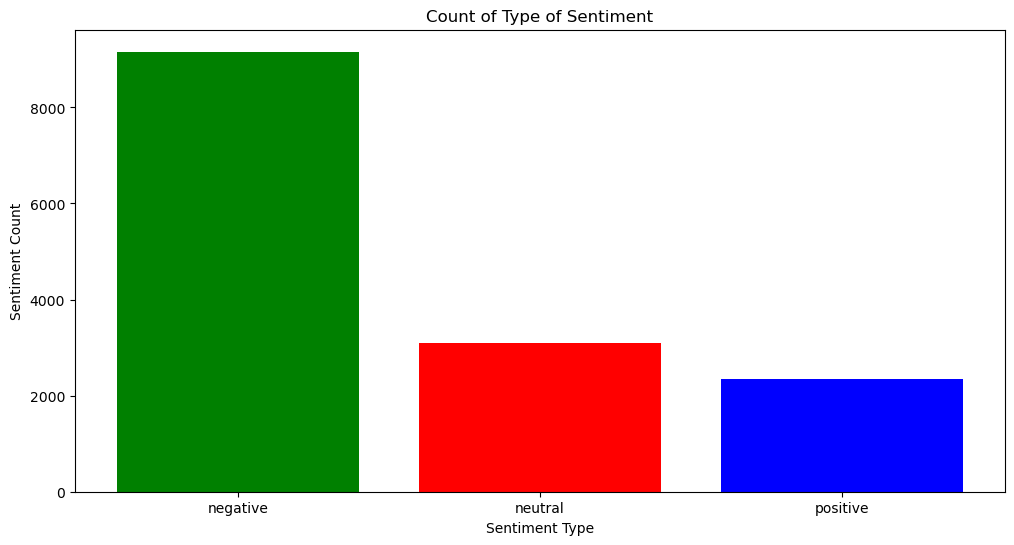

In [6]:
# Plot the overall distribution of sentiments for all the airline
counter = data.airline_sentiment.value_counts()
index = [1,2,3]
plt.figure(1,figsize=(12,6))
plt.bar(index,counter,color=['green','red','blue'])
plt.xticks(index,['negative','neutral','positive'],rotation=0)
plt.xlabel('Sentiment Type')
plt.ylabel('Sentiment Count')
plt.title('Count of Type of Sentiment')

In [7]:
from wordcloud import WordCloud, STOPWORDS

def show_wordcloud(df):
    
    # Join text
    text = ' '.join(df['text'])

    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(['let', 'u', 'still', 'see', 'got', 'way', 'will', 'look', 'guy','flight',\
                      'VirginAmerica','SouthwestAir','JetBlue','USAirways','AmericanAir'])
    stopwords.update(data.airline.unique())

    # Wordcloud
    wordcloud = WordCloud(background_color ='white',
                          stopwords = stopwords,
                          min_font_size = 10).generate(text)

    # Plot the WordCloud image
    
    plt.figure(figsize = (5, 3), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(df['airline'][0], fontdict = {'fontsize':16, 'fontweight':'bold'})
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

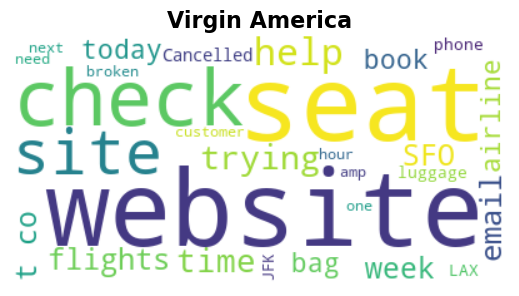

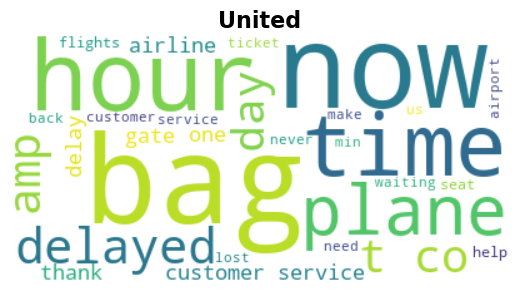

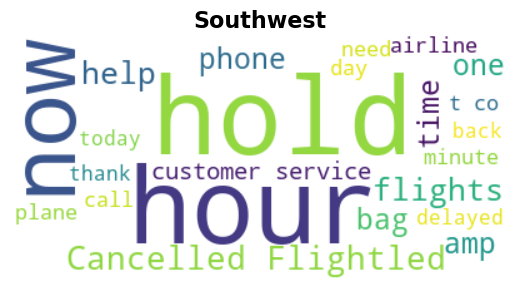

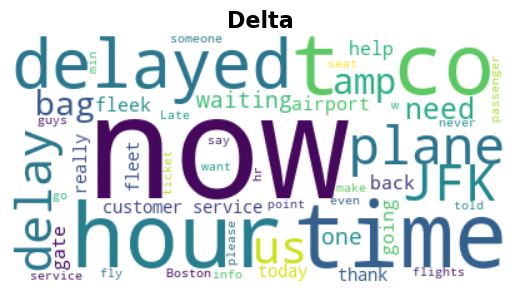

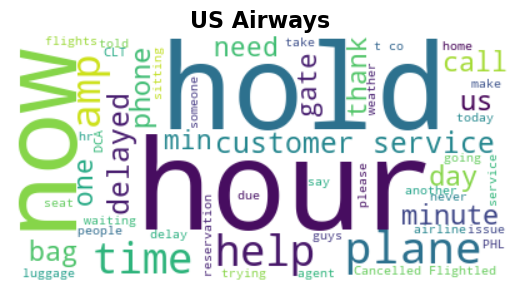

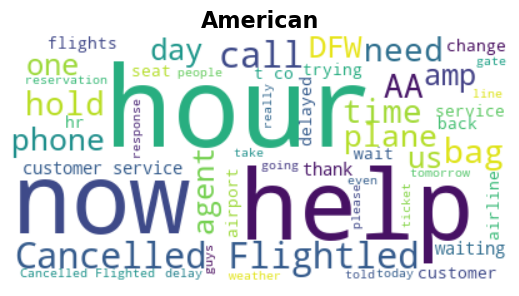

In [8]:
# Show all negative wordclouds
vAmer = data.loc[(data.airline=='Virgin America')&(data.airline_sentiment=='negative')].reset_index(drop=True)
united = data.loc[(data.airline=='United')&(data.airline_sentiment=='negative')].reset_index(drop=True)
sWest = data.loc[(data.airline=='Southwest')&(data.airline_sentiment=='negative')].reset_index(drop=True)
delta = data.loc[(data.airline=='Delta')&(data.airline_sentiment=='negative')].reset_index(drop=True)
usAir = data.loc[(data.airline=='US Airways')&(data.airline_sentiment=='negative')].reset_index(drop=True)
amer = data.loc[(data.airline=='American')&(data.airline_sentiment=='negative')].reset_index(drop=True)
airlines = [vAmer, united, sWest, delta, usAir, amer]
for airline in airlines:
    show_wordcloud(airline)
    print("\n")

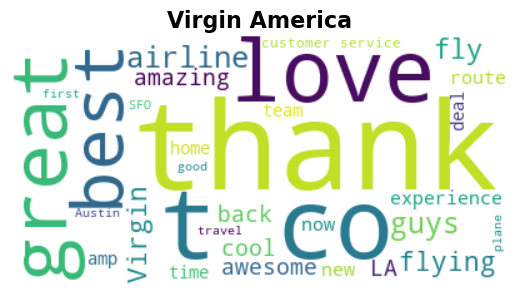

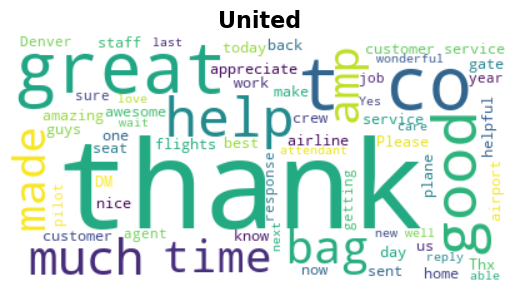

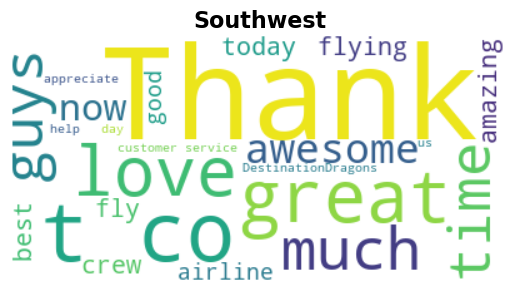

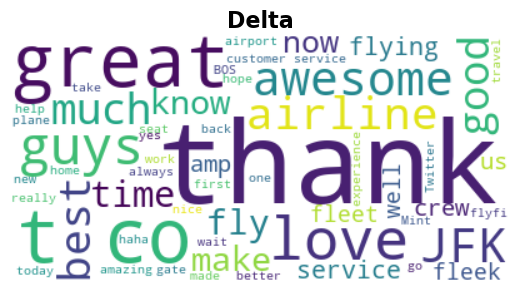

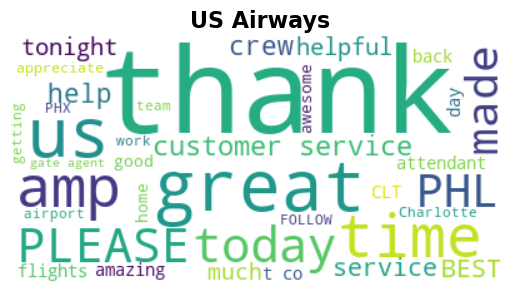

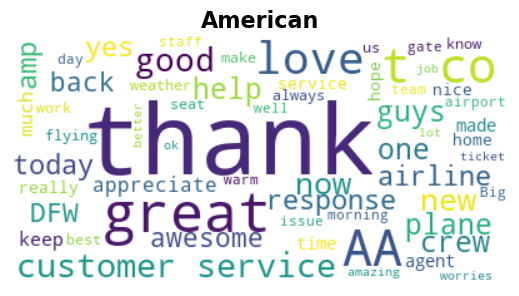

In [9]:
# Show all positive wordclouds
vAmer = data.loc[(data.airline=='Virgin America')&(data.airline_sentiment=='positive')].reset_index(drop=True)
united = data.loc[(data.airline=='United')&(data.airline_sentiment=='positive')].reset_index(drop=True)
sWest = data.loc[(data.airline=='Southwest')&(data.airline_sentiment=='positive')].reset_index(drop=True)
delta = data.loc[(data.airline=='Delta')&(data.airline_sentiment=='positive')].reset_index(drop=True)
usAir = data.loc[(data.airline=='US Airways')&(data.airline_sentiment=='positive')].reset_index(drop=True)
amer = data.loc[(data.airline=='American')&(data.airline_sentiment=='positive')].reset_index(drop=True)
airlines = [vAmer, united, sWest, delta, usAir, amer]
for airline in airlines:
    show_wordcloud(airline)
    print("\n")

# Part 2: Show the distribution of positive/neutral/negative sentiment across all airlines

<AxesSubplot:xlabel='airline', ylabel='count'>

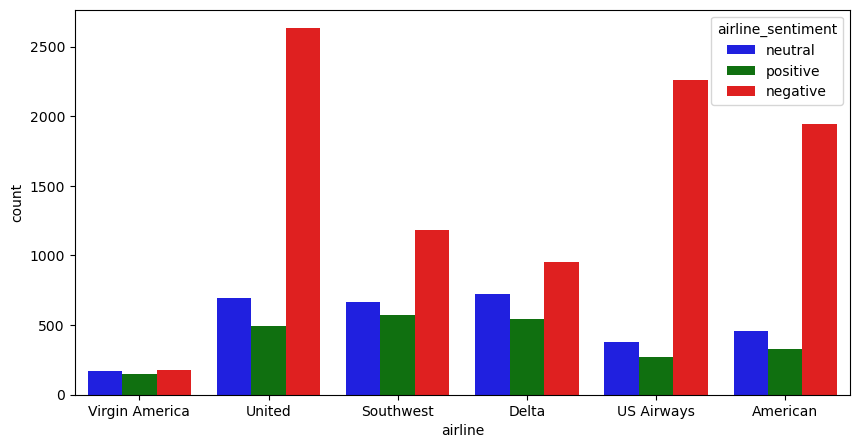

In [118]:
plt.figure(figsize=(10,5))
sns.countplot(data=data,x='airline',hue='airline_sentiment', palette=['blue','green','red'])

# Part 3: Analyze the words distribution on the given "emotions" dataset

In [11]:
df_emotions = pd.read_csv("emotions.csv")
df_emotions.head()

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...


In [12]:
def show_distribution(vectorizer, df_content):
    vectorizer.fit(df_content)
    vecs = vectorizer.transform(df_content)
    sum_mat = np.sum(vecs, axis=0)
    freqs = np.sort(sum_mat).T[::-1]
    plt.plot(list(range(1, sum_mat.shape[1] + 1)), freqs)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.show()
  
    plt.loglog(list(range(1, sum_mat.shape[1] + 1)), freqs)
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.show()

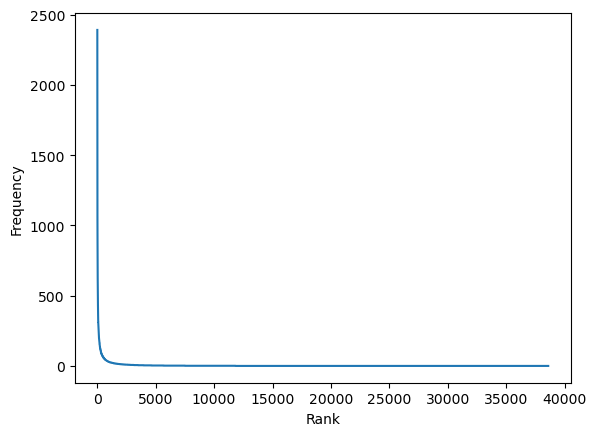

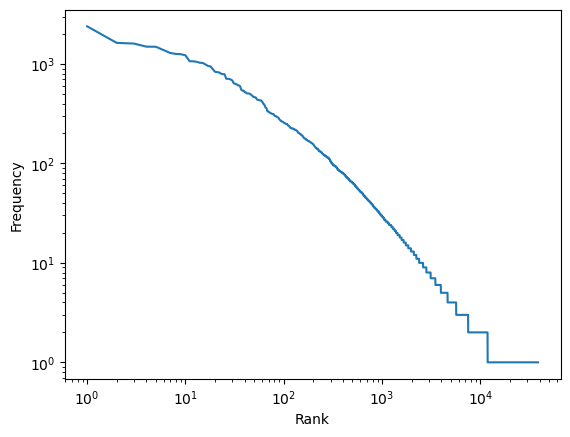

In [13]:
# Convert content to features with ngram_range=(1,1) and plot distribution
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words="english")
show_distribution(vectorizer,df_emotions.content)

## Analysis:
* There are a huge number of words with low frequency while there are a few words with high frequency. 
* Above does not show the words, we will build another plot below to show frequency of words. Since a huge number of words have low frequency, we will only focus on top 20 words.

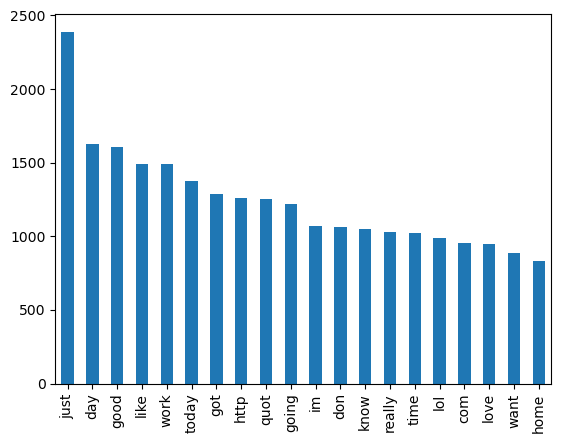

In [14]:
# Convert content to features with ngram_range=(1,1) and fit the vectorizer on content data
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words="english")
vectorizer.fit(df_emotions.content)

# Transform vectors to a matrix object
vecs = vectorizer.transform(df_emotions.content)

# Create table of vocabulary from the vecs matrix object
vocab_table = pd.DataFrame(vecs.todense(), index=df_emotions.index,\
                           columns=vectorizer.get_feature_names_out())

# Calculate the vocabulary frequency and put them into a data frame
freqs = vocab_table.sum(axis=0)
freqs_df = pd.DataFrame.from_dict(dict(freqs), orient='index', columns=(['freq']))

# Plot top 20 words with highest frequency
freqs_df['freq'].sort_values(ascending=False)[:20].plot(kind='bar')
plt.show()

# Part 4: Build the emotion Decision Tree and Naive Bayes classifiers with parameters tuning from emotions data in part 3

In [15]:
# Use stratifed sampling technique to create train/test data
from sklearn.model_selection import train_test_split

stratified_sample = train_test_split(df_emotions, test_size=0.2, stratify=df_emotions[['sentiment']],random_state=18)
train_stratified = stratified_sample[0]
test_stratified = stratified_sample[1]

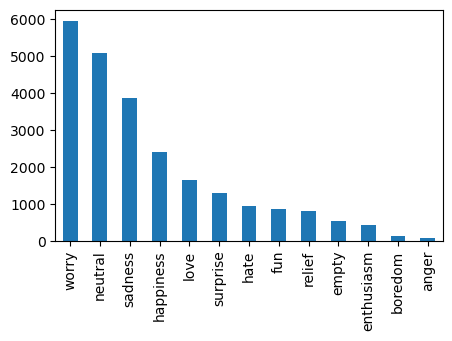

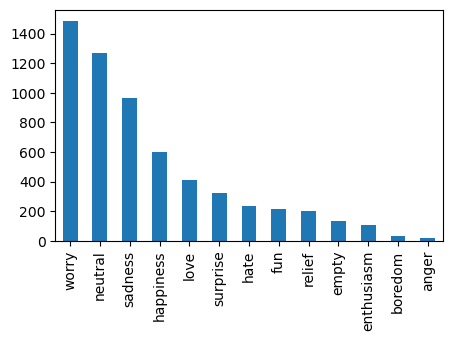

In [16]:
# Visualize train/test data set
plt.figure(figsize=(5,3))
train_stratified['sentiment'].value_counts().plot(kind='bar')
plt.show()
plt.figure(figsize=(5,3))
test_stratified['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [17]:
# Run Decision Tree with min_dfs tuning to search for the parameter that can produce highest f1 score 
min_dfs = np.arange(1, 50, 5)
for i in range(len(min_dfs)):
    dt_model = DecisionTreeClassifier(min_samples_split=0.4,random_state=28)
    dt_features = TfidfVectorizer(min_df = min_dfs[i],ngram_range=(1,3), stop_words= 'english', max_df=0.9, lowercase=True, max_features=2000)
    dt_classifier = make_pipeline(dt_features, dt_model)
    dt_classifier.fit(train_stratified['content'], train_stratified['sentiment'])

    # Compute train/test F1 score
    dt_train_preds_3 = dt_classifier.predict(train_stratified['content'])
    dt_train_f1_3 = f1_score(train_stratified['sentiment'], dt_train_preds_3, average='micro')
    dt_test_preds_3 = dt_classifier.predict(test_stratified['content'])
    dt_test_f1_3 = f1_score(test_stratified['sentiment'], dt_test_preds_3, average='micro')
    print("Train/test F1 for Decision Tree (stratified) with min_df", min_dfs[i],":", dt_train_f1_3, dt_test_f1_3)

Train/test F1 for Decision Tree (stratified) with min_df 1 : 0.3441666666666667 0.319
Train/test F1 for Decision Tree (stratified) with min_df 6 : 0.3435416666666667 0.319
Train/test F1 for Decision Tree (stratified) with min_df 11 : 0.341125 0.31883333333333336
Train/test F1 for Decision Tree (stratified) with min_df 16 : 0.3445416666666667 0.31833333333333336
Train/test F1 for Decision Tree (stratified) with min_df 21 : 0.34258333333333335 0.31816666666666665
Train/test F1 for Decision Tree (stratified) with min_df 26 : 0.34579166666666666 0.31983333333333336
Train/test F1 for Decision Tree (stratified) with min_df 31 : 0.346625 0.3245
Train/test F1 for Decision Tree (stratified) with min_df 36 : 0.34041666666666665 0.32
Train/test F1 for Decision Tree (stratified) with min_df 41 : 0.3408333333333333 0.31733333333333336
Train/test F1 for Decision Tree (stratified) with min_df 46 : 0.33975 0.321


In [18]:
# Run Naive Bayes alpha parameter tuning to search for the parameter that can produce highest f1 score 
alpha_range = np.arange(0, 1, 0.1)

for a in alpha_range:
    tv = TfidfVectorizer(max_df=0.9, ngram_range=(1,3), stop_words='english')
    tv.fit(train_stratified.content)
    NB_stratified = MultinomialNB(alpha=a)
    NB_stratified.fit(tv.transform(train_stratified.content), train_stratified.sentiment)

    NB_train_stratified_pred = NB_stratified.predict(tv.transform(train_stratified.content))
    f1_train_stratified_pred = f1_score(train_stratified.sentiment, NB_train_stratified_pred, average='micro')
    NB_test_stratified_pred = NB_stratified.predict(tv.transform(test_stratified.content))
    f1_test_stratified_pred = f1_score(test_stratified.sentiment, NB_test_stratified_pred, average='micro')
    
    print("Train/test F1 score of NB (stratified) with alpha",a, ": ", f1_train_stratified_pred, f1_test_stratified_pred)

C:\Users\phung\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


Train/test F1 score of NB (stratified) with alpha 0.0 :  0.9890833333333333 0.25516666666666665
Train/test F1 score of NB (stratified) with alpha 0.1 :  0.9754166666666667 0.2886666666666667
Train/test F1 score of NB (stratified) with alpha 0.2 :  0.9294166666666667 0.29133333333333333
Train/test F1 score of NB (stratified) with alpha 0.30000000000000004 :  0.8525833333333334 0.2885
Train/test F1 score of NB (stratified) with alpha 0.4 :  0.7796249999999999 0.286
Train/test F1 score of NB (stratified) with alpha 0.5 :  0.733625 0.2841666666666667
Train/test F1 score of NB (stratified) with alpha 0.6000000000000001 :  0.699875 0.2843333333333333
Train/test F1 score of NB (stratified) with alpha 0.7000000000000001 :  0.6725 0.2813333333333333
Train/test F1 score of NB (stratified) with alpha 0.8 :  0.648 0.2788333333333333
Train/test F1 score of NB (stratified) with alpha 0.9 :  0.6262916666666667 0.2783333333333333


# Part 5: Use Naive Bayes built in part 4 to predict the sentiment in the airline data set. What is accuracy?

In [19]:
# Choose Naive Bayes with alpha = 0.1 as it 
a = 0.1
NB_model = MultinomialNB(alpha=a)
NB_features = TfidfVectorizer(max_df=0.9, ngram_range=(1,3), stop_words='english')
#TfidfVectorizer(ngram_range=(1,3), stop_words= 'english', lowercase=True, max_features=2000, max_df=0.9)
NB_classifier = make_pipeline(NB_features, NB_model)
NB_classifier.fit(train_stratified['content'], train_stratified['sentiment'])

# Compute train/test F1 score
NB_train_preds = NB_classifier.predict(train_stratified['content'])
NB_train_f1 = f1_score(train_stratified['sentiment'], NB_train_preds, average='micro')
NB_test_preds = NB_classifier.predict(test_stratified['content'])
NB_test_f1 = f1_score(test_stratified['sentiment'], NB_test_preds, average='micro')
    
print("Train/test F1 for Naive Bayes (stratified) with alpha ", a,": ", NB_train_f1, NB_test_f1)

Train/test F1 for Naive Bayes (stratified) with alpha  0.1 :  0.9754166666666667 0.2886666666666667


In [20]:
# Use the trained model to predict sentiment in part 
data['sentiment_pred'] = NB_classifier.predict(data['text'])
data[['airline_sentiment','airline_sentiment_confidence','sentiment_pred']].head()

,airline_sentiment,airline_sentiment_confidence,sentiment_pred
0,neutral,1.0000,neutral
1,positive,0.3486,neutral
2,neutral,0.6837,worry
3,negative,1.0000,worry
4,negative,1.0000,worry


In [21]:
# Copy data and convert predicted sentiment to neutral, positive, negative to compare with original airline sentiment in the dataset
# We can see that the f1 score increase significantly when applying the model to the new model
data_3 = data.copy(deep=True)
data_3['sentiment_pred_3'] = data_3['sentiment_pred']\
                                .map({'empty':'neutral','sadness':'negative',\
                                      'enthusiasm':'positive','neutral':'neutral',\
                                      'worry':'negative','surprise':'positive',\
                                      'love':'positive','fun':'positive','hate':'negative',\
                                      'happiness':'positive','boredom':'negative',\
                                      'relief':'neutral','anger':'negative'})

NB_test_f1_airline = f1_score(data_3['airline_sentiment'], data_3['sentiment_pred_3'], average='micro')
print("Compare to airline sentiment in original data set, the error is :", NB_test_f1_airline)

Compare to airline sentiment in original data set, the error is : 0.5637496576280471


# Part 6: What topics are people talking about in their tweets? How does this distribution of topics differ across airlines? 

## We did data text cleaning before building models to predict topics from each text

In [22]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Convert to list
data_4 = data.text.values.tolist()

# Remove Emails
data_4 = [re.sub('\S*@\S*\s?', '', sent) for sent in data_4]

# Remove new line characters
data_4 = [re.sub('\s+', ' ', sent) for sent in data_4]

# Remove distracting single quotes
data_4 = [re.sub("\'", "", sent) for sent in data_4]

pprint(data_4[:10])

['What said.',
 'plus youve added commercials to the experience... tacky.',
 'I didnt today... Must mean I need to take another trip!',
 'its really aggressive to blast obnoxious "entertainment" in your guests '
 'faces &amp; they have little recourse',
 'and its a really big bad thing about it',
 'seriously would pay $30 a flight for seats that didnt have this playing. its '
 'really the only bad thing about flying VA',
 'yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 'Really missed a prime opportunity for Men Without Hats parody, there. '
 'https://t.co/mWpG7grEZP',
 'Well, I didnt…but NOW I DO! :-D',
 'it was amazing, and arrived an hour early. Youre too good to me.']


In [24]:
# Convert sentences in the text data into a list of words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data_4))

print(data_words[:10])

[['what', 'said'], ['plus', 'youve', 'added', 'commercials', 'to', 'the', 'experience', 'tacky'], ['didnt', 'today', 'must', 'mean', 'need', 'to', 'take', 'another', 'trip'], ['its', 'really', 'aggressive', 'to', 'blast', 'obnoxious', 'entertainment', 'in', 'your', 'guests', 'faces', 'amp', 'they', 'have', 'little', 'recourse'], ['and', 'its', 'really', 'big', 'bad', 'thing', 'about', 'it'], ['seriously', 'would', 'pay', 'flight', 'for', 'seats', 'that', 'didnt', 'have', 'this', 'playing', 'its', 'really', 'the', 'only', 'bad', 'thing', 'about', 'flying', 'va'], ['yes', 'nearly', 'every', 'time', 'fly', 'vx', 'this', 'ear', 'worm', 'won', 'go', 'away'], ['really', 'missed', 'prime', 'opportunity', 'for', 'men', 'without', 'hats', 'parody', 'there', 'https', 'co', 'mwpg', 'grezp'], ['well', 'didnt', 'but', 'now', 'do'], ['it', 'was', 'amazing', 'and', 'arrived', 'an', 'hour', 'early', 'youre', 'too', 'good', 'to', 'me']]


In [25]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['plus', 'youve', 'added', 'commercials', 'to', 'the', 'experience', 'tacky']


In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [27]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['say']]


In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

#(0,1): word 0, frequency 1
#(2,1): word 2, frequency 1

[[(0, 1)]]


In [29]:
# Create a dataframe to store resutl
data_tmp = {'num_topics': [0,0,0,0,0], 'Perplexity': [0,0,0,0,0],'Coherence':[0,0,0,0,0]}
lda_result_df = pd.DataFrame(data_tmp)

# Run models with different number of topics n and store data in the dataframe
for n in range(5,10):
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=n, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)
    
    # Compute Perplexity
    print('Perplexity of lda model with ',n, ' topic: ', lda_model.log_perplexity(corpus))

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('Coherence Score of lda model with ',n, ' topic: ', coherence_lda,'\n')
    
    lda_result_df.loc[n,['num_topics','Perplexity','Coherence']] = [n,lda_model.log_perplexity(corpus),coherence_lda]

Perplexity of lda model with  5  topic:  -7.435098726736239
Coherence Score of lda model with  5  topic:  0.32168431024243394 

Perplexity of lda model with  6  topic:  -7.501430251094944
Coherence Score of lda model with  6  topic:  0.3002590982072008 

Perplexity of lda model with  7  topic:  -7.571389934907512
Coherence Score of lda model with  7  topic:  0.3029175538825067 

Perplexity of lda model with  8  topic:  -7.655176824770993
Coherence Score of lda model with  8  topic:  0.31941326349100574 

Perplexity of lda model with  9  topic:  -7.757868635727845
Coherence Score of lda model with  9  topic:  0.3235999896104186 



In [30]:
# Extract final result dataframe    
lda_result_df_final = lda_result_df[5:]
lda_result_df_final

,num_topics,Perplexity,Coherence
5,5.0,-7.435099,0.321684
6,6.0,-7.501430,0.300259
7,7.0,-7.571390,0.302918
8,8.0,-7.655177,0.319413
9,9.0,-7.757869,0.323600


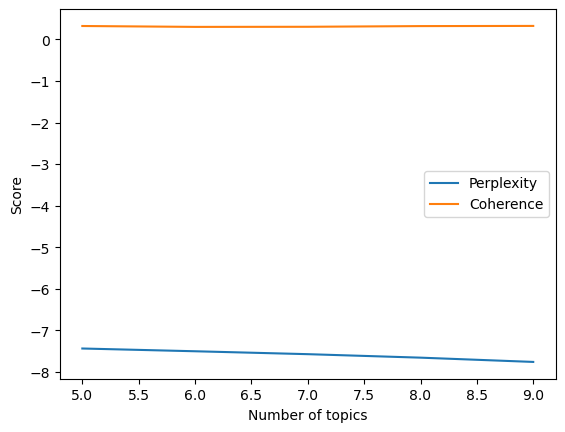

In [31]:
# Plot to show the change of Perplexity and Coherence when n increases
plt.plot(lda_result_df_final['num_topics'],lda_result_df_final[['Perplexity','Coherence']],label=['Perplexity','Coherence'])
plt.legend()
plt.xlabel('Number of topics')
plt.ylabel('Score')
plt.show()

## Based on the above plot, we choose 8 topics as it has low Perplexity and reasonable Coherence. After 8 topics, Coherence seems not increase too much. Also we don't want to choose so many topics as it makes model more complicated.

In [32]:
# Run the model topics with 8 topics
lda_model_8 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
# Print the Keyword in all 8 topics
pprint(lda_model_8.print_topics())
doc_lda_8 = lda_model_8[corpus]

[(0,
  '0.159*"thank" + 0.097*"s" + 0.041*"sit" + 0.036*"luggage" + 0.032*"due" + '
  '0.030*"morning" + 0.022*"refund" + 0.020*"also" + 0.019*"nice" + '
  '0.016*"follow"'),
 (1,
  '0.105*"customer" + 0.080*"service" + 0.071*"minute" + 0.068*"hold" + '
  '0.049*"day" + 0.026*"line" + 0.024*"shitty" + 0.024*"hang" + '
  '0.024*"response" + 0.016*"long"'),
 (2,
  '0.099*"make" + 0.052*"take" + 0.046*"ticket" + 0.042*"money" + 0.038*"gate" '
  '+ 0.024*"travel" + 0.024*"new" + 0.023*"speak" + 0.020*"experience" + '
  '0.018*"appreciate"'),
 (3,
  '0.279*"flight" + 0.073*"cancel" + 0.060*"hour" + 0.038*"wait" + '
  '0.037*"flightle" + 0.035*"late" + 0.031*"m" + 0.029*"tomorrow" + '
  '0.028*"bag" + 0.024*"people"'),
 (4,
  '0.077*"still" + 0.063*"back" + 0.053*"work" + 0.045*"good" + '
  '0.035*"commitment" + 0.035*"see" + 0.032*"ever" + 0.022*"look" + '
  '0.021*"come" + 0.020*"right"'),
 (5,
  '0.134*"get" + 0.060*"need" + 0.040*"change" + 0.039*"try" + 0.036*"know" + '
  '0.034*"agent"

In [34]:
#Visualize the topics for assigning the topics conveniently
pyLDAvis.enable_notebook()
vis = plt_gensim.prepare(lda_model_8, corpus, id2word)
vis

C:\Users\phung\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.428960  0.035932       1        1  19.106319
7      0.023311 -0.423796       2        1  18.382318
5      0.046490  0.100528       3        1  17.106513
6      0.071198  0.061719       4        1  10.898077
1      0.069946  0.064253       5        1  10.224113
2      0.073993  0.055858       6        1   8.367583
4      0.071923  0.052068       7        1   8.189927
0      0.072099  0.053438       8        1   7.725150, topic_info=          Term         Freq        Total Category  logprob  loglift
23      flight  5539.000000  5539.000000  Default  30.0000  30.0000
132        get  2389.000000  2389.000000  Default  29.0000  29.0000
71       thank  1276.000000  1276.000000  Default  28.0000  28.0000
113       call  1650.000000  1650.000000  Default  27.0000  27.0000
256   customer  1114.000000  1114.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
87     awesome    64.997120    65.805623   Topic8  -4.8155   2.5483
1321        dm    57.397189    58.205619   Topic8  -4.9398   2.5467
995     forget    50.641848    51.454802   Topic8  -5.0650   2.5448
940      guess    45.232398    46.040431   Topic8  -5.1780   2.5430
1299    record    43.833694    44.642655   Topic8  -5.2094   2.5424

[271 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1916      1  0.999034         aa
117       4  0.990244       able
1096      6  0.987833   actually
1         5  0.983684        add
503       3  0.998315      agent
...     ...       ...        ...
183       7  0.998806       work
129       4  0.995329      worry
552       7  0.991566      wrong
428       3  0.995621  yesterday
64        4  0.994522        yet

[244 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 6, 7, 2, 3, 5, 1])

In [35]:
# Extract topics and probability from each text data then store in a list. Each text has 8 topics and associated probability 
lda_model_8_topics_dist_list = []
for i, row in enumerate(lda_model_8[corpus]):
    lda_model_8_topics_dist_list.append(row[0])
lda_model_8_topics_dist_list[:2]

[[(0, 0.07578016),
  (1, 0.098718695),
  (2, 0.08053151),
  (3, 0.18437153),
  (4, 0.07909382),
  (5, 0.16565943),
  (6, 0.13693896),
  (7, 0.17890592)],
 [(0, 0.0694054),
  (1, 0.11903676),
  (2, 0.10251626),
  (3, 0.16835673),
  (4, 0.100743786),
  (5, 0.18005143),
  (6, 0.096505865),
  (7, 0.16338372)]]

In [36]:
# For each text, we sort the topic based on the probability and choose to keep the highest probability as the topics
#for that text.
topics_list = []
for i, row in enumerate(lda_model_8_topics_dist_list):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    topics_list.append(row[0][0])
topics_list[:2]
# For example, data.text[0] is assigned to topic number 3, data.text[1] is assigned to topic number 5.

[3, 5]

In [37]:
# Now we need to assign the topic name for each topic generated by the model. It is subjective opinion from the modeler based on frequency of words.
# Assign topic, key_words, topic_name
data['topic'] = topics_list
data['key_words'] = data_lemmatized
data['topic_name'] = data['topic'].map({0:'Baggage service',1:'Customer service',\
                                        2:'Travel experience',3:'Flight experience',\
                                        4:'Customer feedback',5:'Booking and scheduling',\
                                        6:'Flight delays and communication',7:'Customer support'})
# Assign score to airline sentiment
data['airline_sentiment_score'] = data['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})
data[['airline_sentiment','airline','text','sentiment_pred','topic','topic_name','key_words']].head()

,airline_sentiment,airline,text,sentiment_pred,topic,topic_name,key_words
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.,neutral,3,Flight experience,[say]
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...,neutral,5,Booking and scheduling,"[ve, add, commercial, experience, tacky]"
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...,worry,3,Flight experience,"[today, mean, need, take, trip]"
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...,worry,5,Booking and scheduling,"[really, aggressive, blast, obnoxious, enterta..."
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...,worry,7,Customer support,"[really, big, bad, thing]"


## We completed building topics from each text and assign their topic name. Now we perform different visualization to see how customers talk about each airline.

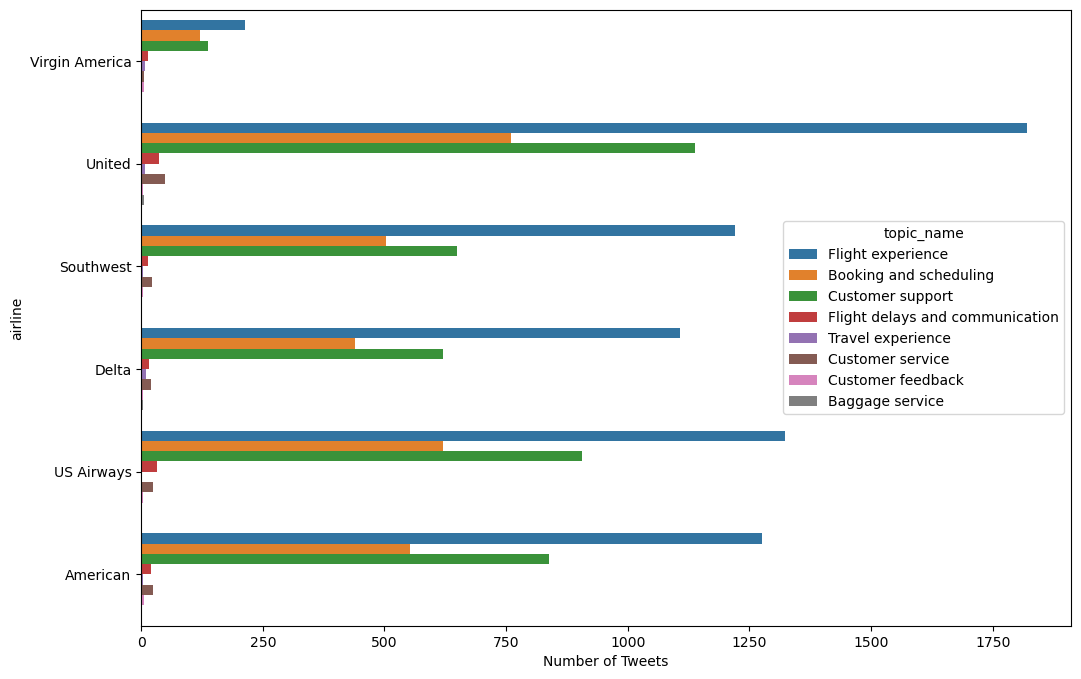

In [39]:
plt.figure(figsize=(12,8))
sns.countplot(data=data,y='airline',hue='topic_name')
plt.xlabel("Number of Tweets")
plt.show()

## Analysis:
* Flight experience, Booking and Scheduling, Customer support are three main topics discussed the most across all airlines.
* Majority of tweets are negative and it is likely that customers are active to make comments when they had bad experiences. The number of tweets about Virgin America is low. When analyze further, it seems a good signal because it indicated that this airline did not have many issues that cause customers to make complain. 

# Part 7: Plot a heat map that shows the sentiment associated with the airlines for different topics and analyze it.

In [40]:
data_5 = data.copy(deep=True)

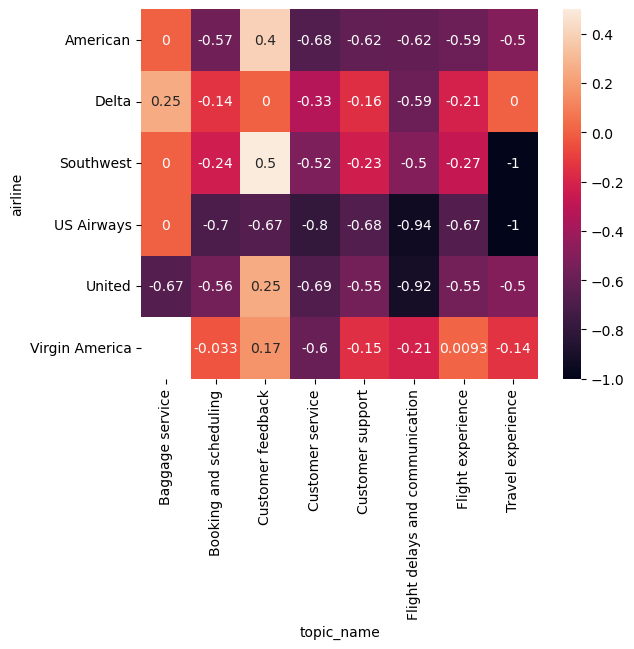

In [41]:
df_heatmap = data_5.pivot_table(values='airline_sentiment_score',index='airline',columns='topic_name',aggfunc=np.mean)
sns.heatmap(df_heatmap,annot=True)
plt.show()

## Analysis:
* In general, all airlines receive a lot of negative sentiment score and none of them have an average score higher than 0.4
* The United, US Airways, American Airline have severe negative sentiment scores.
* Flight delays and communication, Travel Experience, Customer Service are topics that receive negative sentiment scores.
* Delta, Virgin America seem receive overall higher sentiment score compared to other airlines.

# Part 8: Pick Southwest and United. Show how these airlines differ based on the emotions consumers express about them in the tweets.

In [70]:
def viz_emotion_compare(select_airline):
    data_6 = data[data['airline'].isin(select_airline)].reset_index(drop=True)
    
    # Count plot of sentiment 
    plt.figure(figsize=(8,3))
    sns.countplot(data=data_6,x='sentiment_pred',hue='airline')
    plt.title('Number of tweets per emotion of each line')
    plt.legend(loc='upper right')
    plt.ylabel("Number of Tweets")
    plt.show()
    
    # Sentiment Score per emotion of each airline
    plt.figure(figsize=(8,3))
    sns.barplot(data=data_6,x='sentiment_pred',y='airline_sentiment_score',hue='airline')
    plt.title('Sentiment Score per emotion of each airline')
    plt.ylabel("Sentiment Score")
    plt.show()
    
    # Count of tweets per topics of each airline
    plt.figure(figsize=(8,3))
    sns.countplot(data=data_6,y='topic_name',hue='airline')
    plt.title('Distribution of tweets per topic of each airline')
    plt.xlabel("Count of tweets")
    plt.show()
    
    # Sentiment Score distribution per topics of each airline
    plt.figure(figsize=(10,8), dpi= 80)
    sns.violinplot(data=data_6,y='topic_name',x='airline_sentiment_score',hue='airline', inner='quartile', scale='width')
    plt.title('Violin Plot of Sentiment Score by Airline',fontsize = 20)
    plt.xlabel("Sentiment Score")
    plt.show()

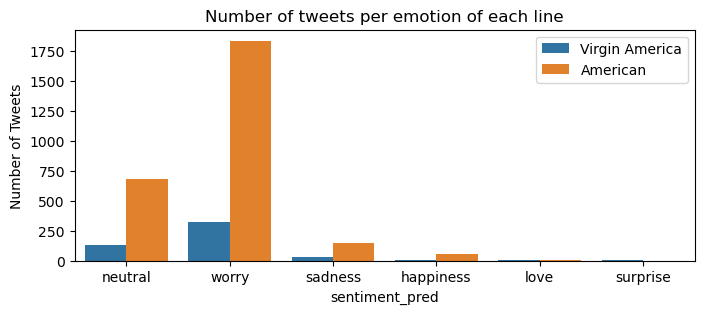

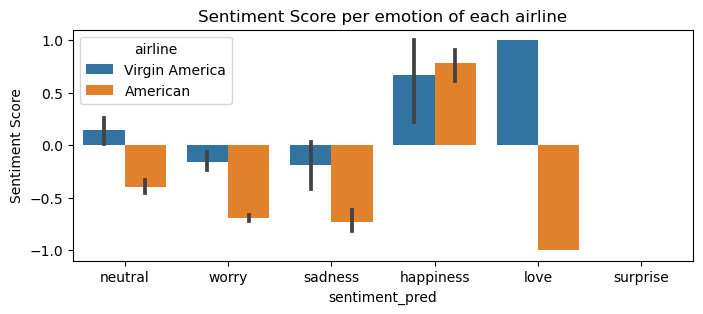

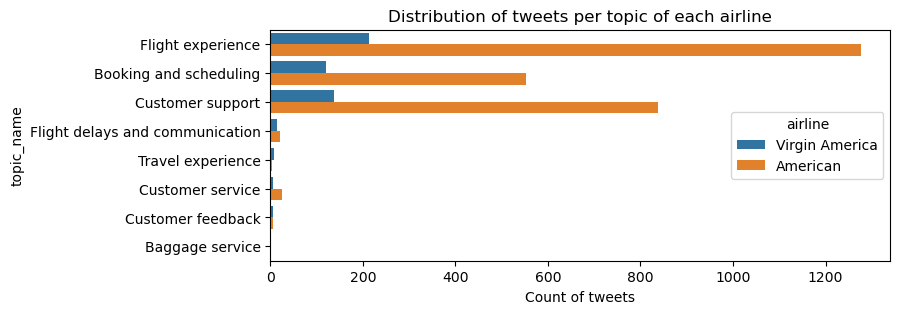

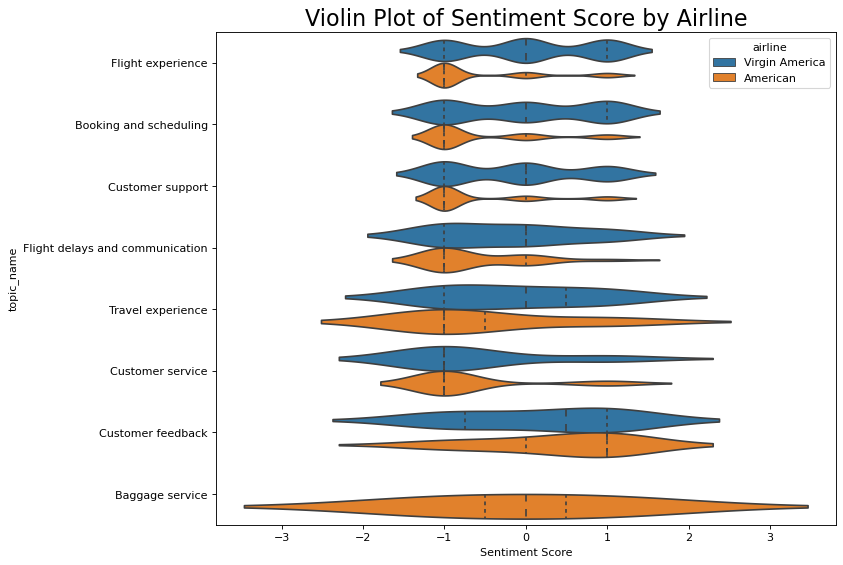

In [71]:
select_airline = ['American','Virgin America']
viz_emotion_compare(select_airline)

## Analysis:
* Majority of tweest belong to "neutral", "worry", or "sadness" emotion class. In each of these emotion class, the number of tweets about American airline is significantly higher than Virgin America. 
* In terms of sentiment score, American Airline receive a much higher negative scores in almost emotion class. One issue I found is that the "love" category has completely oposite scores while the score should be positive. This is where the errors in the Naive Bayes model occur. We classified text under "Love" category, which should be positive, but the actual sentiment is negative for American airline. 
* Top 3 topics that catch attention of customers are Flight Experience, Booking and Scheduling, and Customer Support. Again, the number of tweets in these topics for American Airline is significantly higher than Virgin America. 
* The sentiment score distribution of American Airline is heavier on the negative side for all topics accoring to the violin plot. American Airline also received a lot of tweets about the baggage service while Virgin America did not receive any tweets. 
* Overall, customers had negative experiences at American Airline than Virgin, which is a red flag for American Airline management and hence they need to review and invest to make improvement.

# Part 9: Pick two topics (dimensions) and create a perception map of how all the airlines are located on the two-dimensional map. The axes go from -1 to 1, where 1 denotes that all the tweets pertinent to an airline about that topic are positive, whereas -1 denotes that all tweets are negative.

In [75]:
data_7 = data.copy(deep=True)

In [85]:
# Aggregate to airline and topic name level to compute the average sentiment score 
data_7_topic_score = data_7.groupby(['airline','topic_name'])['airline_sentiment_score'].mean().reset_index()
data_7_topic_score = data_7_topic_score.rename(columns={'airline_sentiment_score':'avg_airline_sentiment_score'})
data_7_topic_score.head(8)

,airline,topic_name,avg_airline_sentiment_score
0,American,Baggage service,0.000000
1,American,Booking and scheduling,-0.567029
2,American,Customer feedback,0.400000
3,American,Customer service,-0.680000
4,American,Customer support,-0.624105
5,American,Flight delays and communication,-0.619048
6,American,Flight experience,-0.586207
7,American,Travel experience,-0.500000


In [110]:
def perception_map(topic_1, topic_2):
    """
    Create perception map between two topics defined above
    """
    select_topic = [topic_1,topic_2]
    
    # Filter selected topics
    data_7_topic_score_group = data_7_topic_score[data_7_topic_score.\
                                                  topic_name.isin(select_topic)].reset_index(drop=True)
    
    # Extract average sentiment score data for topic 1
    data_7_score_topic_1 = data_7_topic_score_group[data_7_topic_score_group.topic_name==topic_1]
    data_7_score_topic_1 = data_7_score_topic_1[['airline','avg_airline_sentiment_score']]
    data_7_score_topic_1 = data_7_score_topic_1.rename(columns={'avg_airline_sentiment_score':f'{topic_1}_score'})
    
    # Extract average sentiment score data for topic 2
    data_7_score_topic_2 = data_7_topic_score_group[data_7_topic_score_group.topic_name==topic_2]
    data_7_score_topic_2 = data_7_score_topic_2[['airline','avg_airline_sentiment_score']]
    data_7_score_topic_2 = data_7_score_topic_2.rename(columns={'avg_airline_sentiment_score':f'{topic_2}_score'})
    
    # Combine average sentiment score data of topic 1 and 2
    data_7_score_map = pd.merge(data_7_score_topic_1,data_7_score_topic_2,how="left",on=["airline"])
    data_7_score_map = data_7_score_map.set_index(['airline'])

    # Create the perception map
    fig, ax = plt.subplots(figsize=(6,5))
    for airline in data_7_score_map.index:
        x = data_7_score_map.loc[airline, f'{topic_1}_score']
        y = data_7_score_map.loc[airline, f'{topic_2}_score']
        ax.scatter(x, y, label=airline)

    # Set the x and y limits of the plot
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])

    # Add labels to the plot
    ax.set_xlabel(topic_1)
    ax.set_ylabel(topic_2)
    ax.set_title(f'Airline Perception Map {topic_1} and {topic_2}')

    # Add a legend to the plot
    ax.legend()

## I tried to create different perception map and provide interesting insights to airline management team. Deep analysis is not the main purpose of this hackathon, so I only performed some major analysis.

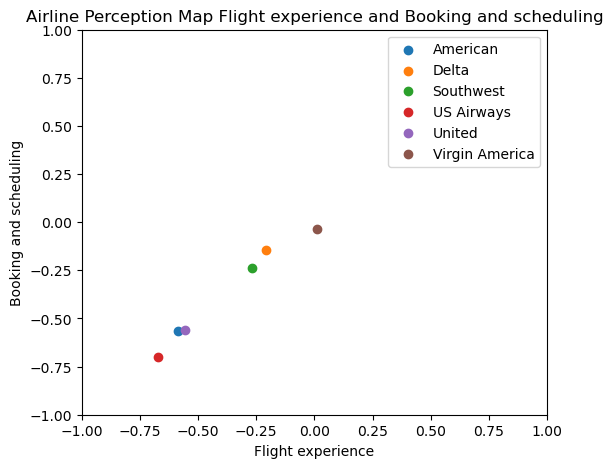

In [109]:
perception_map('Flight experience','Booking and scheduling')

**Analysis: There are two main group in this map. United, US Airways, and American have pretty low sentiment scores on Flight Experience, Booking and Scheduling. The another group including Southwet, Delta, Virgin America have stronger sentiment scores. US Airways is the worst performer and Virgin America is the best based on customer's opinions on Twitter.**

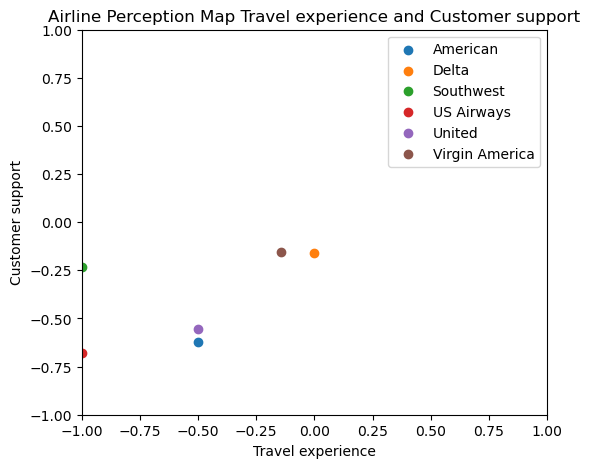

In [111]:
perception_map('Travel experience','Customer support')

**Analysis: There are three seperate groups in this map. Southwest and US Airways have extremely low sentiment score in terms of travel experience. Between these two airline, Southwest is much better than US Airways on the customer support. United and American have pretty low sentiment scores on both travel experience and customer support. Virgin America and Delta have the highest sentiment scores on these dimensions. US Airways is the worst performer and Delta is the best based on customer's opinions on Twitter.**

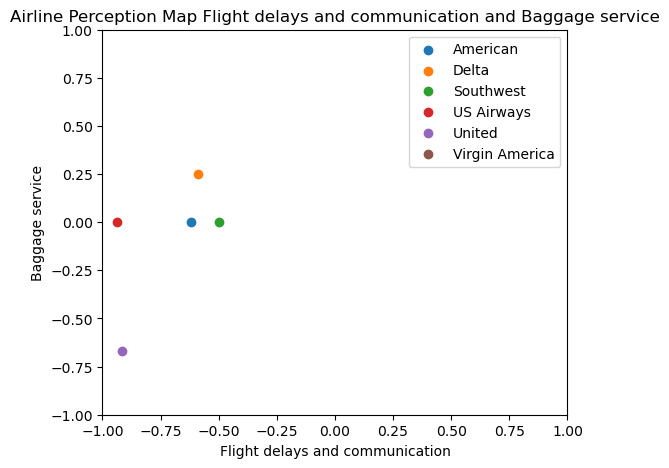

In [115]:
perception_map('Flight delays and communication','Baggage service')

**Analysis: Virgin America did not have negative tweets in these topics, which indicates that they did not have issue with these 2 dimensions. There are three seperate groups in this map. United and US Airways had extremely low sentiment score in terms of flight delays and communication. Between these two airline, US Airways is much better than US Airways on handling baggage service. Southwest, Delta, and American have pretty low sentiment scores on Flight delays and communication while they perform better on baggage service. United is the worst performer and Southwest is the best based on customer's opinions on Twitter.**